### Imports

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, RobertaTokenizer, BertModel, RobertaModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
from tqdm import tqdm  

### Configuration

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'
ROBERTA_MODEL_NAME = 'roberta-base'
MAX_LEN = 128
BATCH_SIZE = 16  
EPOCHS = 5 
LEARNING_RATE = 2e-5

## File Path 
DATA_PATH = os.path.join('data', 'emotions-dataset.parquet') 
CHECKPOINT_DIR = 'models'
LATEST_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
CM_PATH = os.path.join(CHECKPOINT_DIR, 'final_confusion_matrix.png')

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
warnings.filterwarnings("ignore")

### Dataset Class

In [ ]:

class EmotionDataset(Dataset):
    def __init__(self, dataframe, bert_tokenizer, roberta_tokenizer, max_len):
        self.data = dataframe
        self.bert_tokenizer = bert_tokenizer
        self.roberta_tokenizer = roberta_tokenizer
        self.max_len = max_len
        self.texts = dataframe.Sentence   
        self.labels = dataframe.label_int 

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenize for BERT
        bert_inputs = self.bert_tokenizer.encode_plus(
            text, None, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', return_token_type_ids=False,
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        
        # Tokenize for RoBERTa
        roberta_inputs = self.roberta_tokenizer.encode_plus(
            text, None, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', return_token_type_ids=False,
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )

        return {
            'bert_ids': bert_inputs['input_ids'].flatten(),
            'bert_mask': bert_inputs['attention_mask'].flatten(),
            'roberta_ids': roberta_inputs['input_ids'].flatten(),
            'roberta_mask': roberta_inputs['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Defining Model here 
class HybridBertRoberta(nn.Module):
    def __init__(self, num_classes):
        super(HybridBertRoberta, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.roberta = RobertaModel.from_pretrained(ROBERTA_MODEL_NAME)
        self.classifier = nn.Linear(768 * 2, num_classes)

    def forward(self, bert_ids, bert_mask, roberta_ids, roberta_mask):
        bert_output = self.bert(input_ids=bert_ids, attention_mask=bert_mask)
        bert_cls_embedding = bert_output.pooler_output

        roberta_output = self.roberta(input_ids=roberta_ids, attention_mask=roberta_mask)
        roberta_cls_embedding = roberta_output.pooler_output

        combined_embedding = torch.cat((bert_cls_embedding, roberta_cls_embedding), dim=1)
        logits = self.classifier(combined_embedding)
        return logits

### Main Training Function

In [ ]:
def main():
    
    # Setup Device use gpu with cuda activated in it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Using device: {device} ---")
    if device.type == 'cpu':
        print("WARNING: Training on CPU is very slow. Make sure your GPU (CUDA) is enabled.")

    # Loading Data 
    print(f"Loading data from {DATA_PATH}...")
    if not os.path.exists(DATA_PATH):
        print(f"Error: Dataset not found at {DATA_PATH}")
        return

    df = pd.read_parquet(DATA_PATH)
    print("Dynamically mapping text labels to numbers...")
    all_labels = df['Label'].unique()
    all_labels.sort()
    label_to_int = {label: i for i, label in enumerate(all_labels)}
    int_to_label = {i: label for i, label in enumerate(all_labels)}
    NUM_CLASSES = len(all_labels)

    print("---" * 20)
    print(f"Found {NUM_CLASSES} unique labels.")
    print("COPY THIS DICTIONARY INTO YOUR app.py (Streamlit) FILE:")
    print(f"EMOTION_LABELS = {int_to_label}")
    print("---" * 20)

    df['label_int'] = df['Label'].map(label_to_int)
    df = df.dropna(subset=['label_int'])
    df['label_int'] = df['label_int'].astype(int)

    df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    print(f"Full dataset loaded. Training with {len(df_train)} samples.")

    # Tokenizers and DataLoaders 
    print("Loading tokenizers...")
    bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
    roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_NAME)

    print("Creating datasets and dataloaders...")
    train_dataset = EmotionDataset(df_train, bert_tokenizer, roberta_tokenizer, MAX_LEN)
    val_dataset = EmotionDataset(df_val, bert_tokenizer, roberta_tokenizer, MAX_LEN)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Initializing Model and Optimizer 
    print("Initializing model...")
    model = HybridBertRoberta(num_classes=NUM_CLASSES).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    ### Imp =  Checkpoint creation
    start_epoch = 0
    best_accuracy = 0.0

    if os.path.exists(LATEST_CHECKPOINT_PATH):
        print(f"Loading checkpoint from '{LATEST_CHECKPOINT_PATH}'")
        try:
            checkpoint = torch.load(LATEST_CHECKPOINT_PATH, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_accuracy = checkpoint.get('best_accuracy', 0.0)
            print(f"Successfully loaded checkpoint. Resuming training from Epoch {start_epoch + 1}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Starting from scratch.")
            start_epoch = 0
            best_accuracy = 0.0
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Training Loop
    print("--- Starting Training ---")
    for epoch in range(start_epoch, EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        
        model.train()
        total_loss = 0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
        
        for batch in train_progress_bar:
            bert_ids = batch['bert_ids'].to(device)
            bert_mask = batch['bert_mask'].to(device)
            roberta_ids = batch['roberta_ids'].to(device)
            roberta_mask = batch['roberta_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(bert_ids=bert_ids, bert_mask=bert_mask, roberta_ids=roberta_ids, roberta_mask=roberta_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Average Train Loss: {avg_train_loss:.4f}")

        # Checking for Validation
        print("Running validation...")
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                bert_ids = batch['bert_ids'].to(device)
                bert_mask = batch['bert_mask'].to(device)
                roberta_ids = batch['roberta_ids'].to(device)
                roberta_mask = batch['roberta_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(bert_ids=bert_ids, bert_mask=bert_mask, roberta_ids=roberta_ids, roberta_mask=roberta_mask)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Metrics Calculation
        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1} Validation Accuracy: {accuracy:.4f}")
        
        # Checkpoints save 
        is_best = accuracy > best_accuracy
        if is_best:
            best_accuracy = accuracy
            print(f"*** New best model found! Saving to {BEST_MODEL_PATH} ***")
            torch.save(model.state_dict(), BEST_MODEL_PATH)
        
        print(f"Saving latest checkpoint to {LATEST_CHECKPOINT_PATH}...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
            'loss': avg_train_loss,
        }, LATEST_CHECKPOINT_PATH)

    # Now Final Evalution
    print("\n--- Training complete ---")
    print(f"Loading best model from {BEST_MODEL_PATH} for final metrics...")
    
    # Checking and then Loading the best model 
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Final Model Evaluation"):
            bert_ids = batch['bert_ids'].to(device)
            bert_mask = batch['bert_mask'].to(device)
            roberta_ids = batch['roberta_ids'].to(device)
            roberta_mask = batch['roberta_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(bert_ids=bert_ids, bert_mask=bert_mask, roberta_ids=roberta_ids, roberta_mask=roberta_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Final Report 
    print("\n" + "---" * 20)
    print("          FINAL MODEL METRICS (using best_model.pth)")
    print("---" * 20)
    
    target_names = [int_to_label[i] for i in range(NUM_CLASSES)]
    accuracy = accuracy_score(all_preds, all_labels)
    print(f"Overall Validation Accuracy: {accuracy:.4f}")
    
    print("\nFinal Classification Report (F1-Score, Precision, Recall):")
    print(classification_report(all_preds, all_preds, target_names=target_names, zero_division=0))
    
    print("Generating and saving final confusion matrix...")
    cm = confusion_matrix(all_preds, all_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Final Confusion Matrix (Best Model)')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(CM_PATH)
    
    # Displaying plot for comparisons 
    plt.show()
    
    print(f"\nConfusion matrix saved to {CM_PATH}")
    print("Training finished.")

--- Using device: cuda ---
Loading data from data\emotions-dataset.parquet...
Dynamically mapping text labels to numbers...
------------------------------------------------------------
Found 13 unique labels.
COPY THIS DICTIONARY INTO YOUR app.py (Streamlit) FILE:
EMOTION_LABELS = {0: 'anger', 1: 'confusion', 2: 'desire', 3: 'disgust', 4: 'fear', 5: 'guilt', 6: 'happiness', 7: 'love', 8: 'neutral', 9: 'sadness', 10: 'sarcasm', 11: 'shame', 12: 'surprise'}
------------------------------------------------------------
Full dataset loaded. Training with 118175 samples.
Loading tokenizers...
Creating datasets and dataloaders...
Initializing model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No checkpoint found. Starting training from scratch.
--- Starting Training ---

--- Epoch 1/5 ---


Epoch 1 Training: 100%|██████████| 7386/7386 [51:00<00:00,  2.41it/s, loss=0.414]


Epoch 1 Average Train Loss: 0.9779
Running validation...


Epoch 1 Validation: 100%|██████████| 821/821 [01:43<00:00,  7.97it/s]


Epoch 1 Validation Accuracy: 0.6990
*** New best model found! Saving to models\best_model.pth ***
Saving latest checkpoint to models\latest_checkpoint.pth...

--- Epoch 2/5 ---


Epoch 2 Training: 100%|██████████| 7386/7386 [51:00<00:00,  2.41it/s, loss=1.14]  


Epoch 2 Average Train Loss: 0.7523
Running validation...


Epoch 2 Validation: 100%|██████████| 821/821 [01:43<00:00,  7.91it/s]


Epoch 2 Validation Accuracy: 0.6993
*** New best model found! Saving to models\best_model.pth ***
Saving latest checkpoint to models\latest_checkpoint.pth...

--- Epoch 3/5 ---


Epoch 3 Training: 100%|██████████| 7386/7386 [51:33<00:00,  2.39it/s, loss=0.682] 


Epoch 3 Average Train Loss: 0.6345
Running validation...


Epoch 3 Validation: 100%|██████████| 821/821 [01:48<00:00,  7.55it/s]


Epoch 3 Validation Accuracy: 0.6935
Saving latest checkpoint to models\latest_checkpoint.pth...

--- Epoch 4/5 ---


Epoch 4 Training: 100%|██████████| 7386/7386 [52:59<00:00,  2.32it/s, loss=0.561] 


Epoch 4 Average Train Loss: 0.5047
Running validation...


Epoch 4 Validation: 100%|██████████| 821/821 [01:48<00:00,  7.57it/s]


Epoch 4 Validation Accuracy: 0.6894
Saving latest checkpoint to models\latest_checkpoint.pth...

--- Epoch 5/5 ---


Epoch 5 Training: 100%|██████████| 7386/7386 [1:51:40<00:00,  1.10it/s, loss=0.629]   


Epoch 5 Average Train Loss: 0.4016
Running validation...


Epoch 5 Validation: 100%|██████████| 821/821 [05:12<00:00,  2.62it/s]


Epoch 5 Validation Accuracy: 0.6795
Saving latest checkpoint to models\latest_checkpoint.pth...

--- Training complete ---
Loading best model from models\best_model.pth for final metrics...


Final Model Evaluation: 100%|██████████| 821/821 [05:11<00:00,  2.64it/s]



------------------------------------------------------------
          FINAL MODEL METRICS (using best_model.pth)
------------------------------------------------------------
Overall Validation Accuracy: 0.6993

Final Classification Report (F1-Score, Precision, Recall):
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1428
   confusion       1.00      1.00      1.00       734
      desire       1.00      1.00      1.00       272
     disgust       1.00      1.00      1.00       519
        fear       1.00      1.00      1.00       873
       guilt       1.00      1.00      1.00       367
   happiness       1.00      1.00      1.00      3198
        love       1.00      1.00      1.00      1346
     neutral       1.00      1.00      1.00      1541
     sadness       1.00      1.00      1.00      1900
     sarcasm       1.00      1.00      1.00       288
       shame       1.00      1.00      1.00       431
    surprise       1.00  

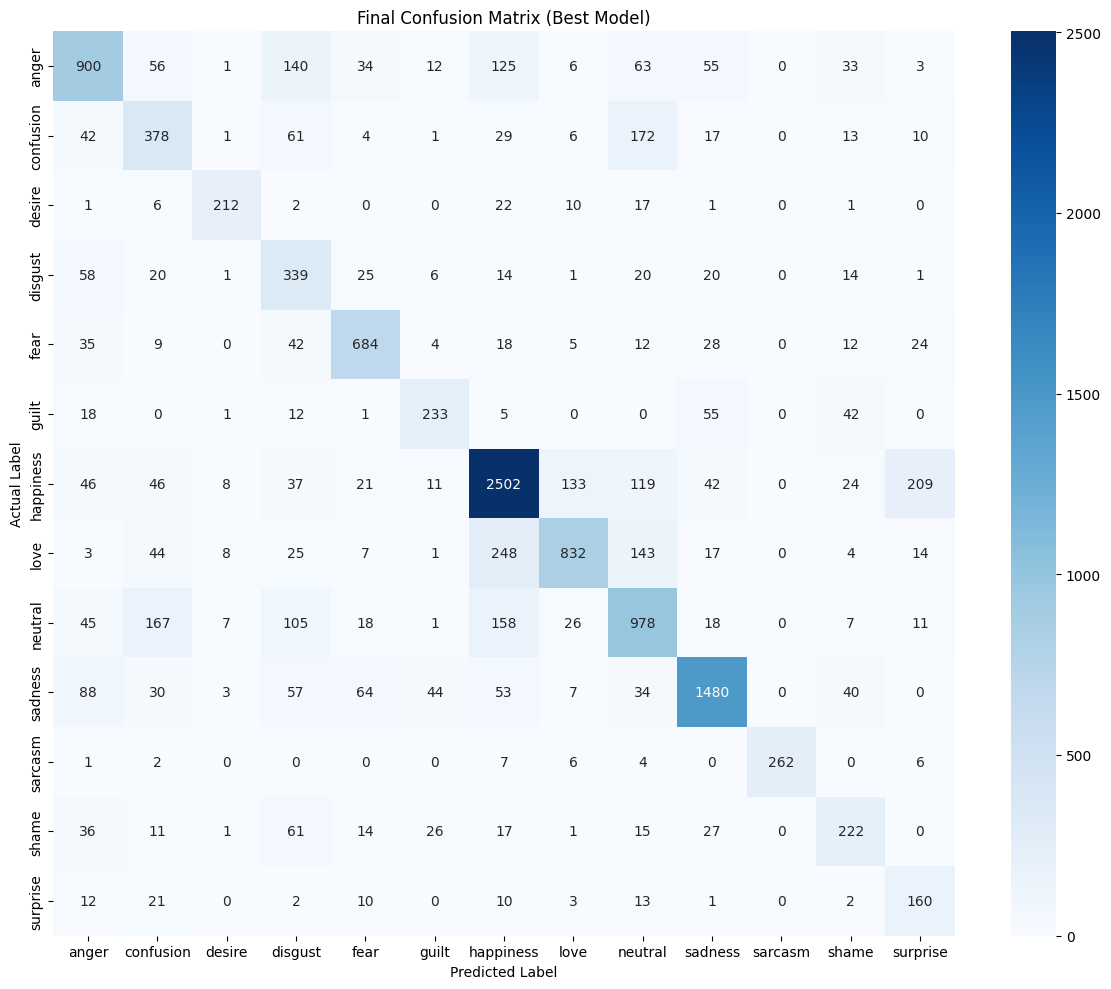


Confusion matrix saved to models\final_confusion_matrix.png
Training finished.


In [ ]:
main()